In [204]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


# 1. Data Processing

In [39]:
#a) Import the data from the website directly

adult_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
                       ,header = None, skipinitialspace=True)

In [40]:
#b) Building the columns

list_of_columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation",
                   "relationship",  "race", "sex", "capital_gain", "capital_loss", "hrs_per_week",
                   "native_country", "salary"]

adult_df.columns = list_of_columns

In [41]:
#c) Checking the dataframe shape 
adult_df.shape

(32561, 15)

In [42]:
#d) Drop the 3rd column from the data which is not needed
adult_df = adult_df.drop(["fnlwgt"], axis=1)

In [43]:
#f) Using the .replace() method to make the following changes to the "salary" column:

#"<=50K" should become 0 
#">50K" should become 1 
def setValue(x): 
    if x == ">50K": return 0
    elif x == "<=50K": return 1
    else: return x
    
adult_df["salary"] = adult_df.salary.map(lambda x : setValue(x)) 

#adult_df.head(10)

In [44]:
adult_df.head(10)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hrs_per_week,native_country,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,1
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,1
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,1
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,1
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,1
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,1
6,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,1
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,0
8,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,0
9,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,0


In [45]:
#g) Creating the X dataframe (just the predictors). 
X = adult_df.drop('salary', axis =1)
X.shape

(32561, 13)

In [46]:
#h) Creating the y dataframe (just the target variable)
y = adult_df[['salary']]
y.shape

(32561, 1)

In [47]:
#i) get dummies
X_encoded = pd.get_dummies(X)
X_encoded.shape

(32561, 107)

In [49]:
#h) Splitting data into train / test set using an 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y, test_size =0.3, random_state = 123 )
X_train.shape, X_test.shape

((22792, 107), (9769, 107))

# 2. Random Forest Classifier - Base Model:

In [50]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=0)

In [51]:
#a) Using the RandomForestClassifier in sklearn. Fitting the model on the training data.
rf_clf.fit(X_train, y_train)

C:\Users\Gokturk\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [264]:
#b) Using the fitted model to predict on test data and getting predicted probabilities as well as predicted classes.
predicted_test = rf_clf.predict(X_test)
probs = rf_clf.predict_proba(X_test)
pred_probs = probs[:,1]
pred_probs

array([1. , 0.6, 1. , ..., 0.4, 1. , 0.8])

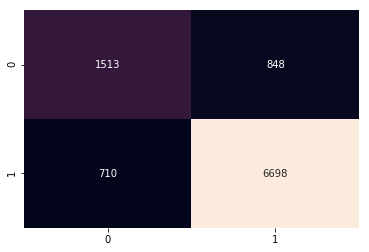

In [57]:
# c) Calculating the confusion matrix and classification report

cm = confusion_matrix(y_test, predicted_test)
sns.heatmap(cm, annot=True, square=False, fmt='', cbar=False)

In [60]:
print(metrics.classification_report(y_test, predicted_test, target_names=None))

             precision    recall  f1-score   support

          0       0.68      0.64      0.66      2361
          1       0.89      0.90      0.90      7408

avg / total       0.84      0.84      0.84      9769



In [64]:
#d) Calculating the AUC score
print(roc_auc_score(y_test, pred_probs))

0.8708899761970759


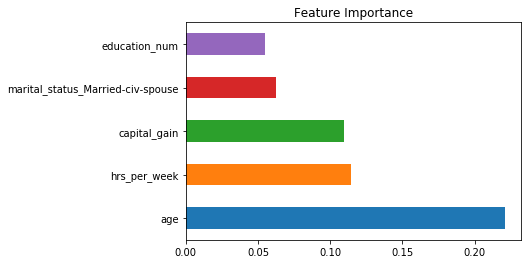

In [256]:
#e) Identifying the top 5 features. 
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_encoded.columns)
feat_importances.nlargest(5).plot(kind='barh',title="Feature Importance")

In [116]:
#f) Using the model from part B, predicting  the train data.
# There are signs of overfitting as classification reports  for train  gives better results.

rf_clf_predict_train = rf_clf.predict(X_train)

print(metrics.classification_report(y_train, rf_clf_predict_train, target_names=None))


             precision    recall  f1-score   support

          0       0.95      0.93      0.94      5480
          1       0.98      0.98      0.98     17312

avg / total       0.97      0.97      0.97     22792



# 3. AdaBoost Classifier - GridSearch:

In [117]:
#creating a simple AdaBoostClassifier only using default parameters
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

ada_clf = AdaBoostClassifier()

In [120]:
#a) Using the AdaBoostClassifier along with the GridSearchCV tool

#creating a dictionary of parameters 
param_grid = {'n_estimators': [100, 200, 300, 400],'learning_rate':[0.2,0.4,0.6,0.8,1, 1.2],'random_state':[0]}

# Creating gridsearch object with various combinations of parameters
ada_Grid = GridSearchCV(ada_clf, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)

ada_Grid.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.7min finished
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400], 'learning_rate': [0.2, 0.4, 0.6, 0.8, 1, 1.2], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [150]:
#b) Using the best estimator from GridSearchCV to predict on test data

print(ada_Grid.best_params_) 
print(ada_Grid.best_estimator_)

{'learning_rate': 1.2, 'n_estimators': 400, 'random_state': 0}
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.2, n_estimators=400, random_state=0)


In [152]:
bestEst = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.2, n_estimators=400, random_state=0)

bestClf = bestEst.fit(X_train,y_train)
bestClf_predict = bestClf.predict(X_test) 

probs = bestClf.predict_proba(X_test)
pred_probs = probs[:,1]
pred_probs

C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       0.78      0.63      0.70      2361
          1       0.89      0.94      0.92      7408

avg / total       0.86      0.87      0.86      9769



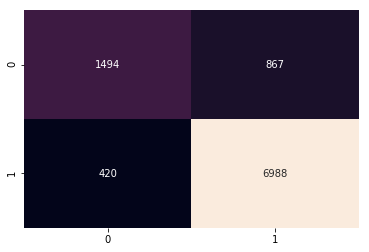

In [153]:
#c) Calculating the confusion matrix and classification report

cm=confusion_matrix(y_test, bestClf_predict)
sns.heatmap(cm, annot=True, square=False, fmt='', cbar=False)
print(metrics.classification_report(y_test, bestClf_predict, target_names=None))


In [154]:
#d) Calculating the AUC score

# limiting to probability for class = 1 
base_probs_best = bestClf.predict_proba(X_test)[:,1]

# calculating roc_auc_score
print(roc_auc_score(y_test, base_probs_best))

0.9266556960068354


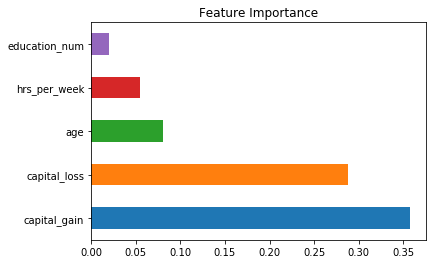

In [257]:
#e) Identifying the top 5 features
# age, education_num, capital_gain  , capital_loss  , hrs_per_week 

feat_importances = pd.Series(bestEst.feature_importances_, index=X_encoded.columns)
feat_importances.nlargest(5).plot(kind='barh',title="Feature Importance")

In [126]:
#f) Using the model from part (b), predict for the train data

# *There is no overfitting for the best estimator as the results look very similar for tes and train sets

bestClf_predict_train = bestClf.predict(X_train)
print(metrics.classification_report(y_train, bestClf_predict_train, target_names=None))

             precision    recall  f1-score   support

          0       0.78      0.65      0.71      5480
          1       0.90      0.94      0.92     17312

avg / total       0.87      0.87      0.87     22792



# 4. Gradient Boosting Classifier - GridSearch:

In [147]:
#a) Using GradientBoostingClassifier along with the GridSearchCV tool

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gradBoost_clf = GradientBoostingClassifier()

In [148]:
#creating a dictionary of parameters 
param_grid = {'n_estimators': [100, 200, 300, 400],'learning_rate':[0.2,0.4,0.8],'max_depth': [1, 2],'random_state':[0]}

# Create gridsearch object with various combinations of parameters
gradboost_Grid = GridSearchCV(gradBoost_clf, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)
gradboost_Grid.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.9min finished
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400], 'learning_rate': [0.2, 0.4, 0.8], 'max_depth': [1, 2], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [149]:
#b) Using the best estimator from GridSearchCV to predict on test data
print(gradboost_Grid.best_params_) 
print(gradboost_Grid.best_estimator_)

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 400, 'random_state': 0}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)


In [169]:
bestEst_grad = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

gradboost_best_Clf = bestEst_grad.fit(X_train,y_train)
gradboost_best_Clf_predict = gradboost_best_Clf.predict(X_test) 
probs = gradboost_best_Clf.predict_proba(X_test)
pred_probs = probs[:,1]
pred_probs

C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       0.79      0.64      0.71      2361
          1       0.89      0.94      0.92      7408

avg / total       0.87      0.87      0.87      9769



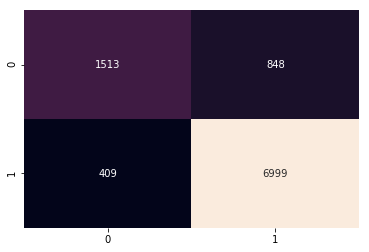

In [170]:
#c) Calculating the confusion matrix and classification report
cm=confusion_matrix(y_test, gradboost_best_Clf_predict)
sns.heatmap(cm, annot=True, square=False, fmt='', cbar=False)
print(metrics.classification_report(y_test, bestClf_predict, target_names=None))

In [171]:
#d) Calculating the AUC score

# limit to probability for class = 1 
base_probs_best = gradboost_best_Clf.predict_proba(X_test)[:,1]

# calculating roc_auc_score
print(roc_auc_score(y_test, base_probs_best))

0.9277883531706281


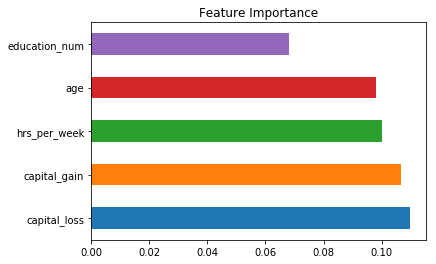

In [258]:
#e) Identifying the top 5 features. ** age, education_num, capital_gain, capital_loss, hrs_per_week 

feat_importances = pd.Series(bestEst_grad.feature_importances_, index=X_encoded.columns)
feat_importances.nlargest(5).plot(kind='barh',title="Feature Importance")

In [172]:
#f) Using the model from part (b), predicting for the train data.
# There doesn't seem to be signs of overfitting, as train and test sets have similar classifiaction report results.

gradboost_best_Clf_predict_train = bestClf.predict(X_train)
print(metrics.classification_report(y_train, gradboost_best_Clf_predict_train, target_names=None))

             precision    recall  f1-score   support

          0       0.80      0.67      0.73      5480
          1       0.90      0.95      0.92     17312

avg / total       0.88      0.88      0.88     22792



# 5. XGBoost - RandomizedSearchCV

In [267]:
#a) Using XGBoost along with the RandomizedSearchCV tool
xgb_clf = XGBClassifier() 

#creating a dictionary of parameters 
param_grid = {'n_estimators': list(range(100,1001,50)),'learning_rate':np.arange(0.1, 1.7, 0.1),
              'max_depth':[1,2],'gamma':np.arange(0, 5.25, 0.25)}

In [268]:
# Creating RandomizedSearchCV object with various combinations of parameters                                           
xgb_grid = RandomizedSearchCV(xgb_clf, param_grid, cv = 5, scoring = 'roc_auc') 
xgb_grid.fit(X_train, y_train) 

C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000], 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6]), 'max_depth': [1, 2], 'gamma': array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ])},
          pre_di

In [270]:
#b) Using the best estimator from RandomizedSearchCV to predict on test data
print(xgb_grid.best_params_) 
print(xgb_grid.best_estimator_)

{'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.2, 'gamma': 0.0}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.0,
       learning_rate=0.2, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)


In [271]:
bestEst_xgb_grid = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.0,
       learning_rate=1.3000000000000003, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=450, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

bestEst_xgb_best_Clf = bestEst_xgb_grid.fit(X_train,y_train)


C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [262]:
bestEst_xgb_grid_predict = bestEst_xgb_best_Clf.predict(X_test) 
probs = bestEst_xgb_best_Clf.predict_proba(X_test)
pred_probs = probs[:,1]
pred_probs

C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

          0       0.79      0.64      0.70      2361
          1       0.89      0.95      0.92      7408

avg / total       0.87      0.87      0.87      9769



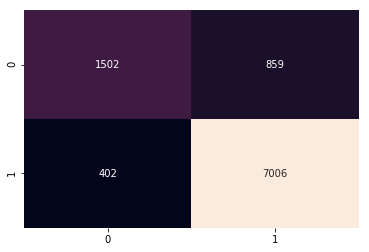

In [213]:
#c) Calculating the confusion matrix and classification report
cm=confusion_matrix(y_test, bestEst_xgb_grid_predict)
sns.heatmap(cm, annot=True, square=False, fmt='', cbar=False)
print(metrics.classification_report(y_test, bestEst_xgb_grid_predict, target_names=None))

In [214]:
#d) Calculating the AUC score

# limiting to probability for class = 1 
base_probs_best = bestEst_xgb_best_Clf.predict_proba(X_test)[:,1]

# calculating roc_auc_score
print(roc_auc_score(y_test, base_probs_best))

0.9286046633423075


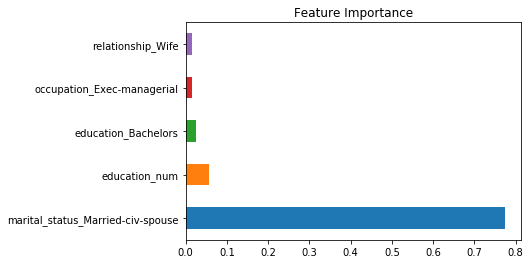

In [273]:
#e) Identifying the top 5 features

feat_importances = pd.Series(bestEst_xgb_grid.feature_importances_, index=X_encoded.columns)
feat_importances.nlargest(5).plot(kind='barh',title="Feature Importance")


In [215]:
#f) Using the model from part (b), predict for the train data.

# There doesn't seem to be signs of overfitting, as train and test sets have similar classification report results.

bestEst_xgb_grid_predict_train = bestEst_xgb_best_Clf.predict(X_train)
print(metrics.classification_report(y_train, bestEst_xgb_grid_predict_train, target_names=None))

             precision    recall  f1-score   support

          0       0.79      0.65      0.71      5480
          1       0.90      0.94      0.92     17312

avg / total       0.87      0.87      0.87     22792



C:\Users\Gokturk\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
